# Group Project - AAI 500
## Group 3
- Victoria Dorn
- Victor Hugo Germano

## Objectives & Hypotesis

- Card price prediction based on features and rarity
- Win rate estimations based on deck composition
- Card synergy compositions 
- Pay to win? influence of price on deck composition and win rate (possible hypothesis: win rate increases as you spend more money? Expensive decks win more?)



In [1]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math

# Data Exploration

In [2]:

cards_data = pd.read_csv('../dataset/cards.csv', sep=';')
cards_data.head()

,artist,colorIdentity,colors,edhrecRank,edhrecSaltiness,finishes,hasFoil,hasNonFoil,isReprint,language,...,originalType,power,rarity,setCode,sourceProducts,supertypes,toughness,type,types,uuid
0,Pete Venters,W,W,21862.0,0.14,nonfoil,False,True,True,English,...,Creature - Human Cleric,4,uncommon,10E,"{""nonfoil"": [""3a10f018-17fe-56a7-91ba-b4bd9867...",NaN,4,Creature — Human Cleric,Creature,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c
1,Pete Venters,W,W,21862.0,0.14,foil,True,False,True,English,...,NaN,4,uncommon,10E,"{""foil"": [""c690e178-661d-5e17-9b29-a5bf6319a84...",NaN,4,Creature — Human Cleric,Creature,b7c19924-b4bf-56fc-aa73-f586e940bd42
2,Volkan Baǵa,W,W,18028.0,0.36,nonfoil,False,True,True,English,...,Creature - Angel,3,uncommon,10E,"{""nonfoil"": [""3210bf43-80f4-5ae4-be77-f6584879...",NaN,3,Creature — Angel,Creature,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c
3,Volkan Baǵa,W,W,18028.0,0.36,foil,True,False,True,English,...,NaN,3,uncommon,10E,"{""foil"": [""c690e178-661d-5e17-9b29-a5bf6319a84...",NaN,3,Creature — Angel,Creature,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a
4,Mark Zug,W,W,23745.0,0.05,nonfoil,False,True,True,English,...,Sorcery,NaN,common,10E,"{""nonfoil"": [""3210bf43-80f4-5ae4-be77-f6584879...",NaN,NaN,Sorcery,Sorcery,55bd38ca-dc73-5c06-8f80-a6ddd2f44382


In [3]:
# Method to plot variables both Discrete and Continuous
def plot_variables(df, columns, num_cols=3, img_height=3, img_width=10, discrete=False, continuous=False):
    n_plots = len(columns)
    n_cols = num_cols
    n_rows = int(math.ceil(n_plots/n_cols))
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=(img_width,img_height)) 
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i]) 
        if discrete:
            df[columns[i]].value_counts().sort_index().plot(kind='bar', ax=ax) 
        if continuous:
            df[columns[i]].hist(ax=ax, grid=False)
            ax.axvline(df[columns[i]].mean(), color='k', linestyle='dashed', linewidth=1, alpha=0.5)
            min_ylim, max_ylim = plt.ylim()
            ax.text(df[columns[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df[columns[i]].mean()))
            
        ax.set_xlabel(columns[i])
    fig.tight_layout()
    fig.supylabel('Count')
    plt.show()


## Column explanation
Adding some info to explain better what some of the data mean, that can be useful on our analysis

- **edhrecRank** = EDHREC is a deck analysis tool for the Commander format (aka EDH) of MTG
- **rarity** = Rarity refers to the distribution of cards in Magic boosters
- **colorIdentity** = is the combination of all colors in its mana cost
- **hasFoil** = premium card finish that can affect price


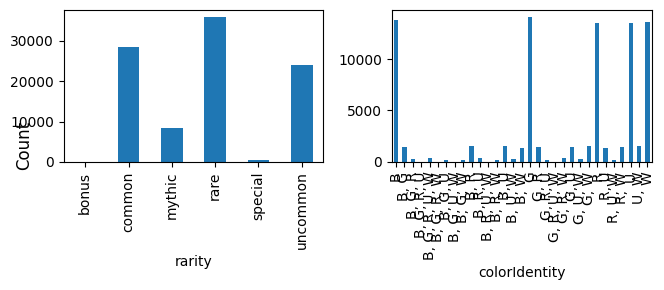

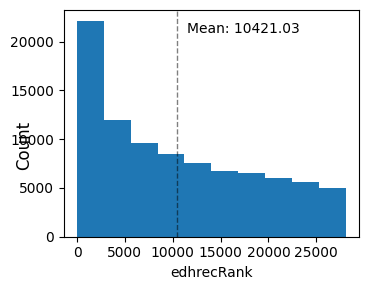

In [4]:
# General EDA presenting some of the data


#cards_data["rarity"]


#sns.histplot(cards_data["edhrecRank"], bins=30, kde=True )

#Plot variables
plot_variables(cards_data, ["rarity", "colorIdentity"], discrete=True)

plot_variables(cards_data, ["edhrecRank"], continuous=True)


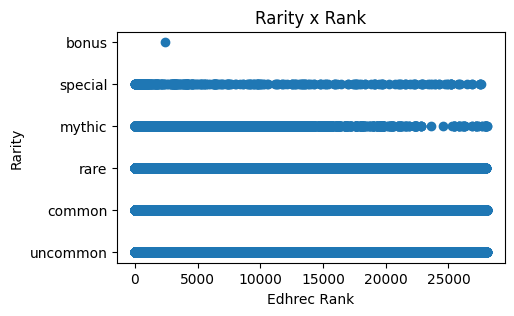

         edhrecRank  edhrecSaltiness       manaValue
count  89737.000000     70825.000000    97145.000000
mean   10421.032395         0.333568       23.580447
std     8301.618169         0.329624     4537.339521
min        1.000000         0.010000        0.000000
25%     2870.000000         0.120000        2.000000
50%     8781.000000         0.240000        3.000000
75%    17123.000000         0.410000        4.000000
max    28071.000000         2.990000  1000000.000000


In [5]:
# Rank based on rarity

# Scatter - Show an good spread on 
plt.figure(figsize=(5,3))
plt.scatter(cards_data["edhrecRank"], cards_data["rarity"])

plt.ylabel('Rarity')
plt.xlabel('Edhrec Rank')
plt.title('Rarity x Rank')
plt.show()
print(cards_data.describe())

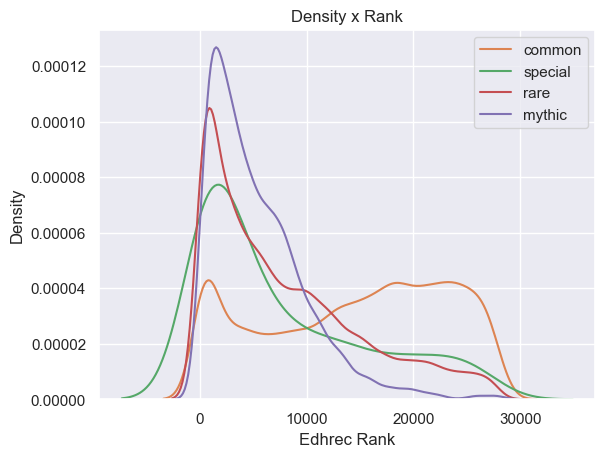

In [6]:

sns.set_theme(style="darkgrid")

# Ploting rarity x rank 
labels = ["uncomon", "common", "special", "rare", "mythic"]
for rarity in labels:
    d = cards_data[cards_data["rarity"] == rarity]
    sns.kdeplot(d["edhrecRank"], label=rarity)

plt.legend()
plt.ylabel('Density')
plt.xlabel('Edhrec Rank')
plt.title('Density x Rank')
plt.show()

